# Deriving Data‑Driven Weights for `complexity_score`

> **Fit a regression on trial duration to let the data pick the weights for each complexity driver**.


1. **Load** the feature table (`features_v2.parquet`).
2. **Select & scale** candidate variables that plausibly drive operational complexity.
3. **Fit** a regularised linear model (Ridge, with cross‑validated `alpha`) on `log(duration_days)`.
4. **Inspect** the learned coefficients and compare with the current hand‑tuned formula.
5. **Build** a new `complexity_score_reg` and explore its distribution.
6. Optionally **export** the coefficients so you can hard‑code them back into the pipeline.

Feel free to tweak the variable list, model family, or scaling strategy.


In [4]:
import pandas as pd
from pathlib import Path

FEATURES_PATH = Path(
    "/Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/"
    "UCL MSc DSML/MSc Project/data/processed/features_v2.parquet"
)

df = pd.read_parquet(FEATURES_PATH)
print(f"Loaded {len(df):,} rows")

# Quick sanity peek
df[['duration_days']].describe().T



Loaded 277,566 rows


,count,mean,std,min,25%,50%,75%,max
duration_days,277566.0,776.541053,672.188392,30.0,273.0,579.0,1096.0,3650.0


In [5]:
df_raw = pd.read_parquet("/Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/UCL MSc DSML/MSc Project/data/interim/ctgov_flat.parquet")
print(f"Total raw files (original): {len(df_raw):,}")

Total raw files (original): 542,076


In [4]:
import numpy as np
from sklearn.preprocessing import RobustScaler

# Candidate predictors
complexity_vars = [
    "assessments_n",
    "site_n",
    "country_n",
    "num_arms",
    "masking_flag",
    "placebo_flag",
    "elig_len",          # <-- raw length, not bucketed
]

X_raw = df[complexity_vars].fillna(0)
scaler = RobustScaler()
X = scaler.fit_transform(X_raw)

y = np.log1p(df["duration_days"])

print("Predictor matrix shape:", X.shape)


Predictor matrix shape: (277566, 7)


In [5]:
from sklearn.linear_model import RidgeCV
import pandas as pd
import numpy as np

alphas = np.logspace(-3, 3, 13)     # 0.001 … 1000
ridge = RidgeCV(alphas=alphas, cv=5).fit(X, y)

print("Chosen alpha:", ridge.alpha_)

coef = pd.Series(ridge.coef_, index=complexity_vars)
coef.sort_values(ascending=False)


Chosen alpha: 1000.0


elig_len         0.063259
country_n        0.001437
site_n           0.001437
assessments_n    0.000000
masking_flag     0.000000
placebo_flag    -0.067919
num_arms        -0.098776
dtype: float64

In [6]:
# Use only positive contributions (clip negatives to 0 to keep monotonicity)
w_pos = coef.clip(lower=0)

df['complexity_score_reg'] = (X * w_pos.values).sum(axis=1)

# Rescale 0–100 for explainability
min_, max_ = df['complexity_score_reg'].min(), df['complexity_score_reg'].max()
df['complexity_score_reg'] = 100 * (df['complexity_score_reg'] - min_) / (max_ - min_)

df[['complexity_score', 'complexity_score_reg']].describe()


,complexity_score,complexity_score_reg
count,277566.000000,277566.000000
mean,16.549639,0.903668
std,65.607078,1.311514
min,1.000000,0.000000
25%,3.000000,0.256468
50%,5.000000,0.468081
75%,7.000000,1.060199
max,7023.000000,100.000000


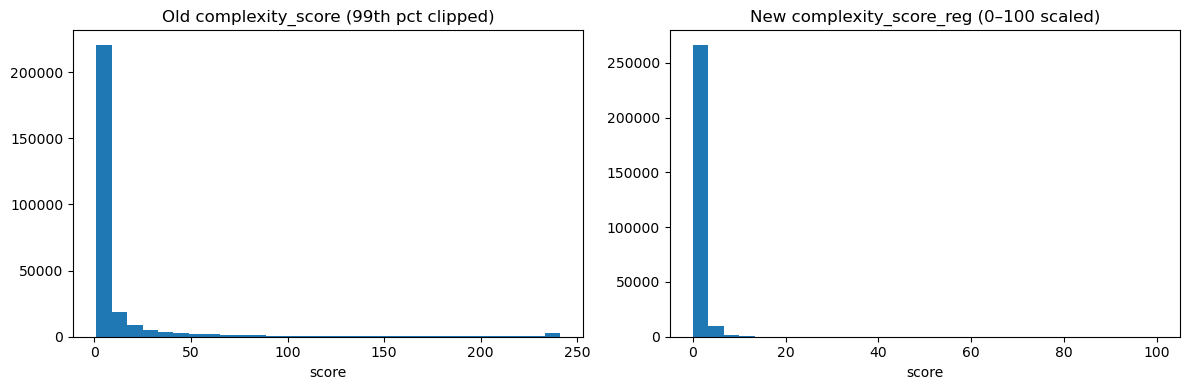

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['complexity_score'].clip(upper=df['complexity_score'].quantile(0.99)), bins=30)
axes[0].set_title('Old complexity_score (99th pct clipped)')
axes[0].set_xlabel('score')

axes[1].hist(df['complexity_score_reg'], bins=30)
axes[1].set_title('New complexity_score_reg (0–100 scaled)')
axes[1].set_xlabel('score')

plt.tight_layout()
plt.show()


In [8]:
# Optional: export weights to JSON / CSV
weights_path = FEATURES_PATH.parent / 'complexity_weights_ridge.json'
coef.to_json(weights_path, indent=2)
print("Saved weights to", weights_path)


Saved weights to /Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/UCL MSc DSML/MSc Project/data/processed/complexity_weights_ridge.json
